In [1]:

"""
- For retraining, prepare folder structure as
    - root_folder_name
        - class 1
            - file1
            - file2
        - class 2
            - file1
            - file2

"""
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os

imagePath = '/home/golden/Projects/gazelle_identification/gazelle/data/extracted/gazelle_head/2017_mar22_0d2a4552.0.jpg'
modelFullPath = '/home/golden/Projects/gazelle_identification/gazelle/output_graph.pb'
labelsFullPath = '/home/golden/Projects/gazelle_identification/gazelle/output_labels.txt' 

dataset_labels = None


def create_graph():
    """Creates a graph from saved GraphDef file and returns a saver."""
    # Creates graph from saved graph_def.pb.
    with tf.gfile.FastGFile(modelFullPath, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        _ = tf.import_graph_def(graph_def, name='')

def create_labels():
    f = open(labelsFullPath, 'rb')
    lines = f.readlines()
    labels = [str(w).replace('b\'', '') for w in lines]
    labels = [str(w).replace('\\n\'', '') for w in labels]
    return labels
    

def run_inference_on_image(image, labels, num_predictions):
    
    if labels == None:
        labels = create_labels()
    answer = None

    if not tf.gfile.Exists(image):
        tf.logging.fatal('File does not exist %s', image)
        return answer

    image_data = tf.gfile.FastGFile(image, 'rb').read()

    

    with tf.Session() as sess:

        softmax_tensor = sess.graph.get_tensor_by_name('final_result:0')
        predictions = sess.run(softmax_tensor,
                               {'DecodeJpeg/contents:0': image_data})
       
        predictions = np.squeeze(predictions)

        top_k = predictions.argsort()[-num_predictions:][::-1]  # Getting top 5 predictions
        #f = open(labelsFullPath, 'rb')
        #lines = f.readlines()
        #labels = [str(w).replace('b\'', '') for w in lines]
        #labels = [str(w).replace('\\n\'', '') for w in labels]
        
        return_labels = []
        return_scores = []
        for node_id in top_k:
            return_labels.append(labels[node_id])
            return_scores.append(predictions[node_id])
        
        return [return_labels, return_scores]

In [15]:
# Creates graph from saved GraphDef.
create_graph()
#create_labels()
dataset_labels = create_labels()
image = '/home/golden/Projects/gazelle_identification/gazelle/data/high_count/OryxF015/2017_Mar11_0D2A0956.0.jpg'
print('guess: ', run_inference_on_image(image, dataset_labels, 5))

guess:  [['oryxf015', 'seratf012', 'seratf014', 'seratf009', 'oryxf006'], [0.1054856, 0.079414301, 0.062847629, 0.061991781, 0.045620199]]


In [44]:
class_folder = '/home/golden/Projects/gazelle_identification/gazelle/data/high_count'
folders_path = [x[0] for x in os.walk(class_folder)][1:]
folders_train = folders_path[3::4]
folders_test = folders_path[1::4]
folders_eval = folders_path[2::4]
folders_label = [os.path.basename(f) for f in folders_path[::4]]

folders_images = [x[2] for x in os.walk(class_folder)][1:]


def grade_labels(image_label, image_folder, image_list, print_incorrect, num_top_predictions):
    result = []
    if len(image_list) == 0:
        print('No images in ' , image_folder)
        return False
        
    correct = [[] for _ in range(len(num_top_predictions))]

    for image_name in image_list:
        image = os.path.join(image_folder, image_name)
        labels = run_inference_on_image(image, dataset_labels, max(num_top_predictions))[0]
        for indx_top, num_top in enumerate(num_top_predictions):
            in_top_five = False
            for label in labels[:num_top]:
                #case insensitive
                if (label.lower() == image_label.lower()):
                    in_top_five = True
            correct[indx_top].append(int(in_top_five))
            if print_incorrect:
                if not in_top_five:
                    img = mpimg.imread(image)
                    plt.imshow(img)
                    plt.figure()
    percent_correct = [0] * len(num_top_predictions)
    for indx in range(len(num_top_predictions)):
        percent_correct[indx] = sum(correct[indx])/(len(correct[indx]))
    
    return percent_correct


top_nums = [1, 5, 10]

total_train_error = [0] * len(top_nums)
total_test_error = [0] * len(top_nums)
total_eval_error = [0] * len(top_nums)

total_count = {'train': 0, 'test': 0, 'eval':0}


for class_num in range(len(folders_train)):
#for class_num in range(1):
    print('Results for ', folders_label[class_num])

    test_images = [x for x in os.walk(folders_test[class_num])][0]
    test_images = test_images[2:][0]
    train_images = [x for x in os.walk(folders_train[class_num])][0]
    train_images = train_images[2:][0]
    eval_images = [x for x in os.walk(folders_eval[class_num])][0]
    eval_images = eval_images[2:][0]

    test_percent = grade_labels(
        folders_label[class_num], folders_test[class_num], test_images, False, top_nums) 
    train_percent = grade_labels(
        folders_label[class_num], folders_train[class_num], train_images, False, top_nums)
    eval_percent = grade_labels(
        folders_label[class_num], folders_eval[class_num], eval_images, False, top_nums)
    
    if train_percent:
        for ind in range(len(train_percent)):
            total_train_error[ind] += train_percent[ind]
            total_count['train'] += 1
            if test_percent:
                total_test_error[ind] += test_percent[ind]
                total_count['test'] += 1
            if eval_percent:
                total_eval_error[ind] += eval_percent[ind]
                total_count['eval'] += 1

    print('test: ', test_percent)
    print('train: ', train_percent)
    print('eval: ', eval_percent)


for indx, top_num in enumerate(top_nums):
    print('Top ', top_num, ' percent error test images: ', total_test_error[indx] / 57)   
    print('Top ', top_num, ' percent error train images: ', total_train_error[indx] / 58) 
    print('Top ', top_num, ' percent error eval images: ', total_eval_error[indx] / 58)   

Results for  ZebraF037
test:  [0.2, 0.7, 0.9]
train:  [0.46808510638297873, 0.851063829787234, 0.9361702127659575]
eval:  [0.3333333333333333, 0.8888888888888888, 0.8888888888888888]
Results for  OryxM013
test:  [0.6, 0.9, 0.9]
train:  [0.76, 0.92, 1.0]
eval:  [0.375, 0.5, 0.875]
Results for  ZebraF083
No images in  /home/golden/Projects/gazelle_identification/gazelle/data/high_count/ZebraF083/test
test:  False
train:  [0.8823529411764706, 1.0, 1.0]
eval:  [0.25, 0.5, 0.75]
Results for  OryxF026
test:  [0.3333333333333333, 1.0, 1.0]
train:  [0.5416666666666666, 0.875, 0.9583333333333334]
eval:  [0.14285714285714285, 0.42857142857142855, 0.7142857142857143]
Results for  OryxF029
test:  [0.0, 0.3333333333333333, 0.3333333333333333]
train:  [0.6666666666666666, 1.0, 1.0]
eval:  [0.0, 0.6, 0.8]
Results for  SeratF003
test:  [0.0, 0.5, 0.5]
train:  [0.6470588235294118, 0.9411764705882353, 1.0]
eval:  [0.25, 0.5, 0.75]
Results for  OryxM003
test:  [0.25, 1.0, 1.0]
train:  [0.9565217391304348

test:  [0.0, 1.0, 1.0]
train:  [0.6875, 0.9375, 0.9375]
eval:  [0.6666666666666666, 1.0, 1.0]
Results for  SeratM006
test:  [0.16666666666666666, 0.5, 0.8333333333333334]
train:  [0.8125, 0.875, 0.9375]
eval:  [0.2857142857142857, 0.7142857142857143, 0.7142857142857143]
Results for  OryxF004
test:  [0.16666666666666666, 0.3333333333333333, 0.3333333333333333]
train:  [0.6666666666666666, 0.9444444444444444, 0.9444444444444444]
eval:  [0.0, 0.3333333333333333, 0.5]
Results for  OryxM009
test:  [0.23076923076923078, 0.6153846153846154, 0.9230769230769231]
train:  [0.5806451612903226, 0.9032258064516129, 0.967741935483871]
eval:  [0.5, 0.8, 1.0]
Top  1  percent error test images:  0.29927255407131576
Top  1  percent error train images:  0.7036624750024829
Top  1  percent error eval images:  0.39007269212644463
Top  5  percent error test images:  0.6352642512859231
Top  5  percent error train images:  0.8928628700369702
Top  5  percent error eval images:  0.6631577882338532
Top  10  percen

In [43]:
print(total_count['train'])
print(len(folders_train))

174
58


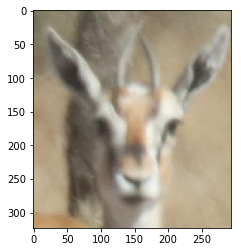

In [4]:
img = mpimg.imread(image)
plt.imshow(img)

In [5]:
class_folder = '/home/golden/Projects/gazelle_identification/gazelle/data/high_count'
images_folders = [x[0] for x in os.walk(class_folder)][1:]

In [6]:
images_folders

['/home/golden/Projects/gazelle_identification/gazelle/data/high_count/ZebraF037',
 '/home/golden/Projects/gazelle_identification/gazelle/data/high_count/ZebraF037/test',
 '/home/golden/Projects/gazelle_identification/gazelle/data/high_count/ZebraF037/eval',
 '/home/golden/Projects/gazelle_identification/gazelle/data/high_count/ZebraF037/train',
 '/home/golden/Projects/gazelle_identification/gazelle/data/high_count/OryxM013',
 '/home/golden/Projects/gazelle_identification/gazelle/data/high_count/OryxM013/test',
 '/home/golden/Projects/gazelle_identification/gazelle/data/high_count/OryxM013/eval',
 '/home/golden/Projects/gazelle_identification/gazelle/data/high_count/OryxM013/train',
 '/home/golden/Projects/gazelle_identification/gazelle/data/high_count/ZebraF083',
 '/home/golden/Projects/gazelle_identification/gazelle/data/high_count/ZebraF083/test',
 '/home/golden/Projects/gazelle_identification/gazelle/data/high_count/ZebraF083/eval',
 '/home/golden/Projects/gazelle_identification/ga

In [28]:
class_folder = '/home/golden/Projects/gazelle_identification/gazelle/data/high_count'
folders_path = [x[0] for x in os.walk(class_folder)][1:]
folders_train = folders_path[3::4]
folders_test = folders_path[1::4]
folders_eval = folders_path[2::4]
folders_label = [os.path.basename(f) for f in folders_path[::4]]

folders_images = [x[2] for x in os.walk(class_folder)][1:]
#for class_num in range(len(folders_train)):
for class_num in range(1):
    print('Results for ', folders_label[class_num])
    for image_name in [x for x in os.walk(folders_train[class_num])]:
        #image = os.path.join(folders_train[class_num], image_name)
        print(image_name)

Results for  ZebraF037
('/home/golden/Projects/gazelle_identification/gazelle/data/high_count/ZebraF037/train', [], ['2017_Apr04_0D2A9647.0.jpg', '2017_Apr05_0D2A0113.0.jpg', '2017_Mar15_0D2A1818.0.jpg', '2017_Apr12_0D2A5219.0.jpg', '2017_Apr10_0D2A1125.0.jpg', '2017_Mar31_0D2A7638-2.0.jpg', '2017_Apr05_0D2A0114.0.jpg', '2017_Apr12_0D2A5195.0.jpg', '2017_Mar23_0D2A4709.0.jpg', '2017_Mar31_0D2A7634.0.jpg', '2017_Apr12_0D2A5189.0.jpg', '2017_Apr04_0D2A9646.0.jpg', '2017_Apr12_0D2A5218.0.jpg', '2017_Mar31_0D2A7637-2.0.jpg', '2017_Mar31_0D2A7646-2.0.jpg', '2017_Mar31_0D2A7636-2.0.jpg', '2017_Mar31_0D2A7635.0.jpg', '2017_Apr08_0D2A9989.0.jpg', '2017_Mar11_0D2A1105.0.jpg', '2017_Mar19_0D2A3242.0.jpg', '2017_Apr06_0D2A9129.0.jpg', '2017_Apr08_0D2A0013.0.jpg', '2017_Mar23_0D2A4682-2.0.jpg', '2017_Apr03_0D2A9111.0.jpg', '2017_Apr06_0D2A9128.0.jpg', '2017_Mar23_0D2A4708.0.jpg', '2017_Apr12_0D2A5196.0.jpg', '2017_Apr05_0D2A0115.0.jpg', '2017_Apr04_0D2A9644.0.jpg', '2017_Apr12_0D2A5217.0.jpg', '20

In [19]:
folders_path = [x[0] for x in os.walk(class_folder)][1:]

In [6]:
#create_graph()
image = '/home/golden/Projects/gazelle_identification/gazelle/data/high_count/OryxF015/2017_Mar11_0D2A0956.0.jpg'
print('guess: ', run_inference_on_image(image, labels))

guess:  [['oryxf015', 'seratf012', 'seratf014', 'seratf009', 'oryxf006'], [0.1054856, 0.079414301, 0.062847629, 0.061991781, 0.045620199]]


In [36]:
test = [7] * 10
test_1 = [2] * 10
test_2 = test / test_1

TypeError: unsupported operand type(s) for /: 'list' and 'list'

In [35]:
test_2

[9, 9, 9, 9, 9, 9, 9, 9, 9, 9]

In [59]:
test[2]

IndexError: tuple index out of range

In [17]:
test = None
print(len(test))

TypeError: object of type 'NoneType' has no len()

In [22]:
test = [0] * 10
test[0] = 10

In [30]:
test[:10]

[10, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [27]:
test

[10, 0, 0, 0, 0, 0, 0, 0, 0, 0]